In [0]:
!pip install tensorflow-gpu==2.0.0.rc0

In [0]:
import tensorflow as tf

keras = tf.keras

In [0]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [0]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [0]:
print(raw_train)
print(raw_validation)
print(raw_test)

<DatasetV1Adapter shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<DatasetV1Adapter shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<DatasetV1Adapter shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline 

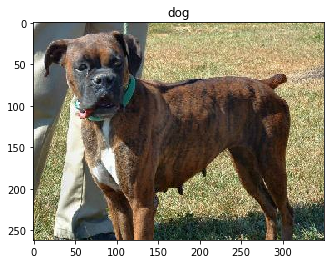

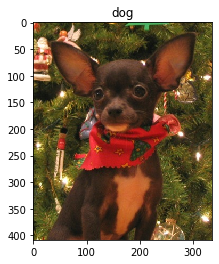

In [0]:
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

In [0]:
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [0]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [0]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [0]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [0]:
for image_batch, label_batch in train_batches.take(1):
   pass

image_batch.shape

TensorShape([32, 160, 160, 3])

In [0]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [0]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [0]:
base_model.trainable = False

In [0]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [0]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [0]:
prediction_layer = keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [0]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [0]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
initial_epochs = 10
validation_steps=20


In [0]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/10
582/582 [==============================] - 54s 93ms/step - loss: 0.3926 - accuracy: 0.8009 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
582/582 [==============================] - 48s 83ms/step - loss: 0.2121 - accuracy: 0.9083 - val_loss: 0.1391 - val_accuracy: 0.9230
Epoch 3/10
582/582 [==============================] - 48s 83ms/step - loss: 0.1689 - accuracy: 0.9303 - val_loss: 0.1291 - val_accuracy: 0.9278
Epoch 4/10
582/582 [==============================] - 48s 83ms/step - loss: 0.1527 - accuracy: 0.9359 - val_loss: 0.1236 - val_accuracy: 0.9316
Epoch 5/10
582/582 [==============================] - 49s 84ms/step - loss: 0.1394 - accuracy: 0.9420 - val_loss: 0.1154 - val_accuracy: 0.9355
Epoch 6/10
582/582 [==============================] - 48s 83ms/step - loss: 0.1355 - accuracy: 0.9436 - val_loss: 0.1092 - val_accuracy: 0.9411
Epoch 7/10
582/582 [==============================] - 48s 83ms/step - loss: 0.1309 - accuracy: 0.9445 - val_loss: 0.1103 - val_a

In [0]:

import matplotlib.image as mpimg

In [0]:
path='/content/ct44.jpg'
img=tf.keras.preprocessing.image.load_img(path,target_size=(160,160,3))
img=tf.keras.preprocessing.image.img_to_array(img)
img=img/255
img=img.reshape(1,160,160,3)

In [0]:
pred=model.predict_classes(img)

In [0]:
if pred==0:
  res='cat'
else:
  res='dog'

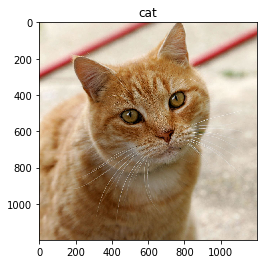

In [0]:
get_label_name = metadata.features['label'].int2str
File_name = mpimg.imread(path)
plt.imshow(File_name)
plt.title(res)
plt.show()
